# Double-bracket Iteration other cost functions and respective scheduling

This notebook presents two additional cost functions for the double-bracket flow: least-squares and energy fluctuation with their respectice scheduling methods.

In [192]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCostFunction
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *

### Least-squares

The cost function is defined as: $\frac{1}{2}||D-H_k||^2 =\frac{1}{2}(||D||^2+||H||^2) -Tr(D H_k)$ as in https://epubs.siam.org/doi/abs/10.1137/S0036141092229732?journalCode=sjmael. We seek to maximize this function at each iteration.

In [184]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 9
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)



[Qibo 0.2.5|INFO|2024-03-20 10:46:15]: Using qibojit (numba) backend on /CPU:0


In [189]:
# generate data for plotting sigma decrease of the first step
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/2**nqubits
s_space = np.linspace(1e-5, 0.3, 100)
off_diagonal_norm_diff = []
potential = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
    potential.append(dbi_eval.least_squares(D=d))

# grid_search
#step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
print('grid_search step:', step_grid)
# hyperopt
#step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
# polynomial
#step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
print('polynomial_approximation step:', step_poly)

grid_search step: 0.39394545454545454
hyperopt_search step: 0.017463998220887386
polynomial_approximation step: 0.0010293852957746303


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The minimum for cost function in the tested range is: 0.39394545454545454


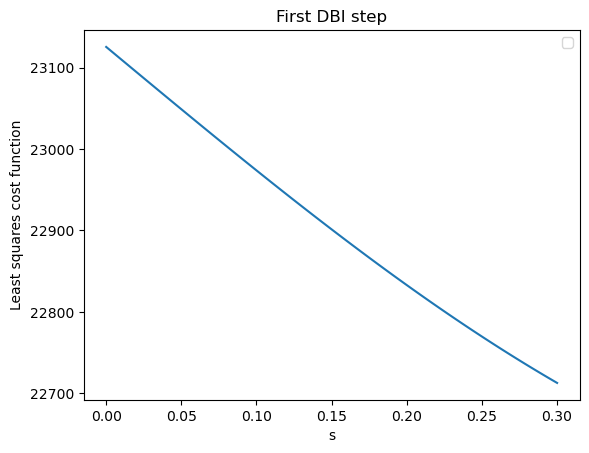

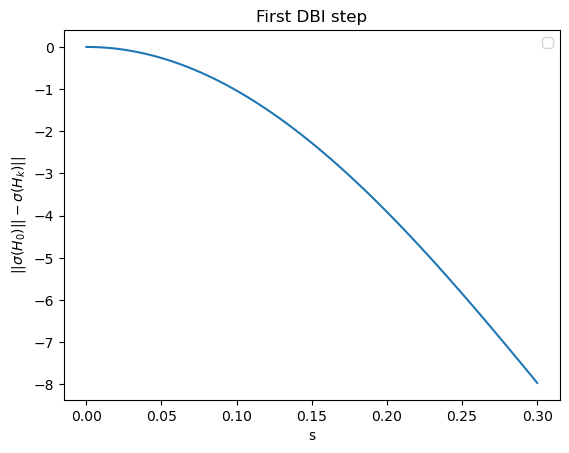

In [191]:
# Plot the results
plt.figure()
plt.plot(s_space, potential)
plt.xlabel('s')
#plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
#plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
#plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.title('First DBI step')
plt.ylabel('Least squares cost function')
plt.legend()
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff)
#plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
#plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
#plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

Comparison of the least-squares cost function with the original cost function using the polynomial scheduling method

In [5]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
off_diagonal_norm_diff = [dbi.off_diagonal_norm]
off_diagonal_norm_diff_least_squares = [dbi.off_diagonal_norm]
iters = 100
dbi_ls = deepcopy(dbi)
cost = DoubleBracketCostFunction.off_diagonal_norm
dbi_od = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
for _ in range(iters):
    step_poly = dbi_od.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_od(step_poly,d=d)
    step_poly = dbi_ls.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_ls(step_poly,d=d)
    off_diagonal_norm_diff.append(dbi_od.off_diagonal_norm)
    off_diagonal_norm_diff_least_squares.append(dbi_ls.off_diagonal_norm)

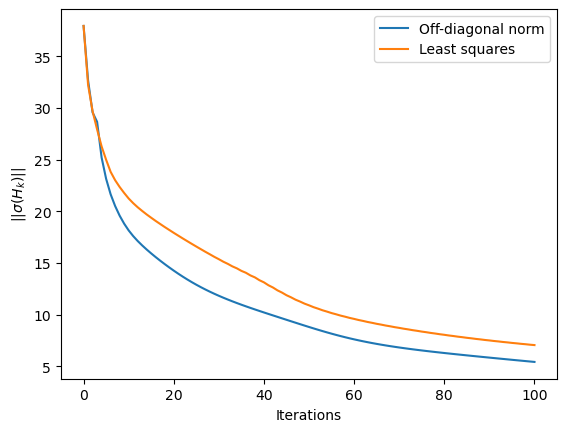

In [6]:
plt.figure()
plt.plot(range(iters+1), off_diagonal_norm_diff, label=r'Off-diagonal norm')
plt.plot(range(iters+1), off_diagonal_norm_diff_least_squares, label=r'Least squares')
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()


### Energy fluctuation

This cost function is defined as: $\Xi_k^2 (\mu) = \langle \mu | H_k^2| \mu \rangle - \langle \mu | H_k| \mu \rangle^2$

In [183]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 3
h = 1.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the energy fluctuation cost function
cost = DoubleBracketCostFunction.energy_fluctuation
# define the state
state = 0
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost, state=state)
print(np.real(dbi.h.matrix))

[Qibo 0.2.5|INFO|2024-03-20 10:23:17]: Using qibojit (numba) backend on /CPU:0


[[-3. -1. -1. -0. -1. -0. -0. -0.]
 [-1.  1. -0. -1. -0. -1. -0. -0.]
 [-1. -0.  1. -1. -0. -0. -1. -0.]
 [-0. -1. -1.  1. -0. -0. -0. -1.]
 [-1. -0. -0. -0.  1. -1. -1. -0.]
 [-0. -1. -0. -0. -1.  1. -0. -1.]
 [-0. -0. -1. -0. -1. -0.  1. -1.]
 [-0. -0. -0. -1. -0. -1. -1. -3.]]


In [175]:
# generate data for plotting sigma decrease of the first step
d = np.diag(np.linspace(2**nqubits,1,2**nqubits))
s_space = np.linspace(1e-5, 0.9, 1000)
off_diagonal_norm_diff = []
fluctuation = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
    fluctuation.append(dbi_eval.energy_fluctuation(state=state))

# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
# polynomial
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
print('polynomial_approximation step:', step_poly)

grid_search step: 0.33334
hyperopt_search step: 0.33819673200950817
polynomial_approximation step: 0.10712604100508318


The minimum for cost function in the tested range is: 0.33334


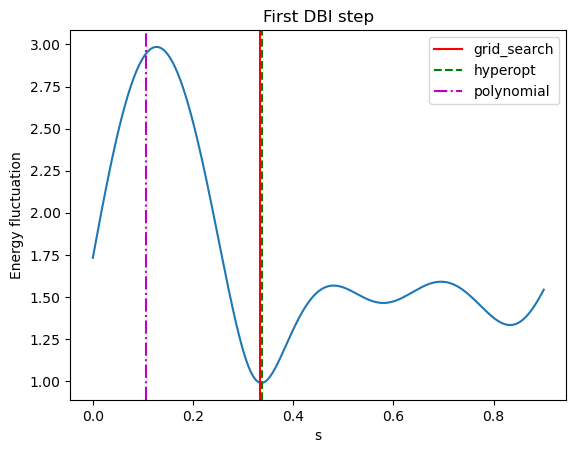

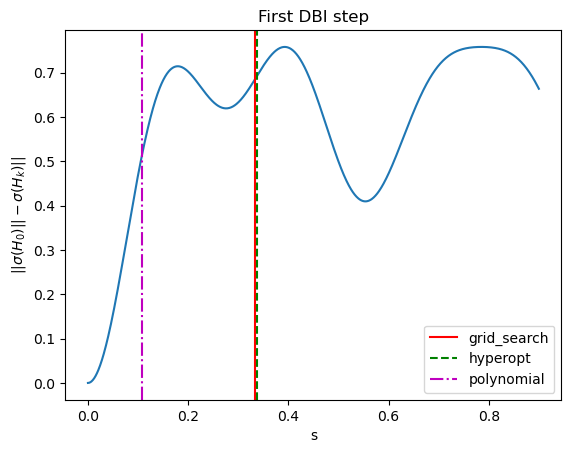

In [176]:
# Plot the results
plt.figure()
plt.plot(s_space, fluctuation)
plt.xlabel('s')
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label ='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.title('First DBI step')
plt.ylabel('Energy fluctuation')
plt.legend()
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

In [177]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
off_diagonal_norm_diff = [dbi.off_diagonal_norm]
energy_fluc = [dbi.energy_fluctuation(state=state)]
iters = 10
dbi_ = deepcopy(dbi)
for _ in range(iters):
    step_poly = dbi_.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_(step_poly,d=d)
    off_diagonal_norm_diff.append(dbi_.off_diagonal_norm)
    energy_fluc.append(dbi_.energy_fluctuation(state=state))

Text(0, 0.5, 'Energy fluctuation')

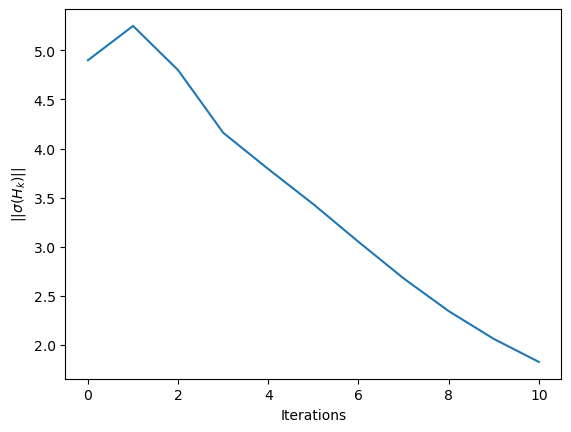

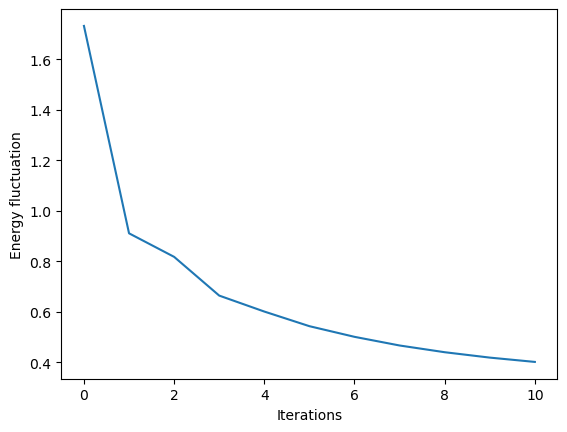

In [178]:
plt.figure()
plt.plot(range(iters+1), off_diagonal_norm_diff)
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')

plt.figure()
plt.plot(range(iters+1), energy_fluc)
plt.xlabel('Iterations')
plt.ylabel(r'Energy fluctuation')


In [179]:
iters = 30
states = [0,1,2,3,4,5,6,7]
energy = np.empty((len(states),iters))


d = (np.diag(np.linspace(1,2**nqubits,2**nqubits)))
for i in range(len(states)):
    dbi_ = deepcopy(dbi)
    dbi_.state = states[i]
    for j in range(iters):
        step_poly = dbi_.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
        if step_poly is not None:
            dbi_(step_poly,d=d)
        energy[i,j] = dbi_.h.matrix[states[i],states[i]]
    

C:\Users\andre\AppData\Local\Temp\ipykernel_23312\3703842558.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  energy[i,j] = dbi_.h.matrix[states[i],states[i]]


Eigenvalues: [-4.00000000e+00 -3.46410162e+00 -8.06606266e-16  3.61709753e-17
  2.32474753e-15  2.00000000e+00  2.00000000e+00  3.46410162e+00]


Text(0.5, 0, 'Iterations')

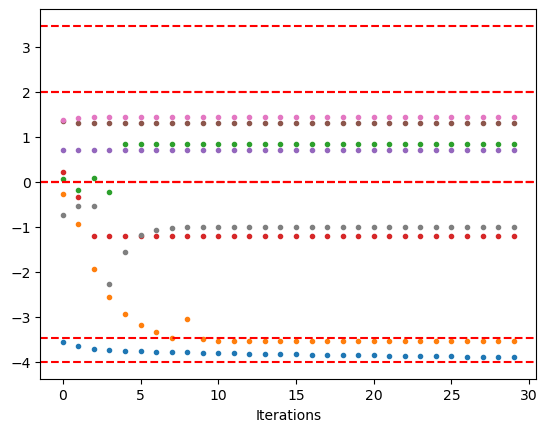

In [181]:
eigvals = np.linalg.eigh(dbi_.h.matrix)[0]
print('Eigenvalues:', eigvals )
plt.figure()
for i in range(len(states)):
    plt.plot(range(iters), energy[i,:],'.', label='State ' + str(states[i]))
for eigvals in eigvals:
    plt.axhline(y=eigvals, color='r', linestyle='--')
plt.xlabel('Iterations')


### Gradients for finding optimal $D$

An advantage of the least-squares cost function is that one can use gradient descent and the learning is more stable than with the off-diagonal cost function.

Text(0, 0.5, 'Diagonal elements')

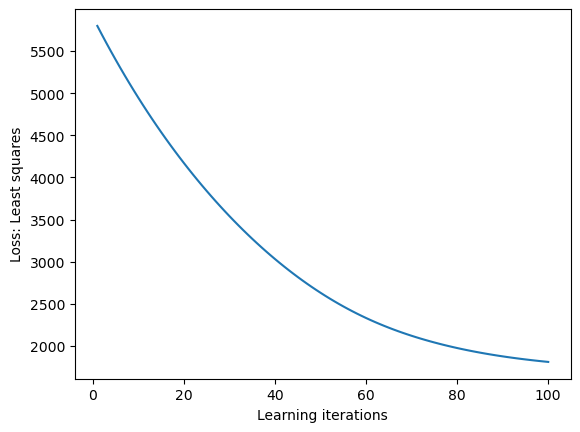

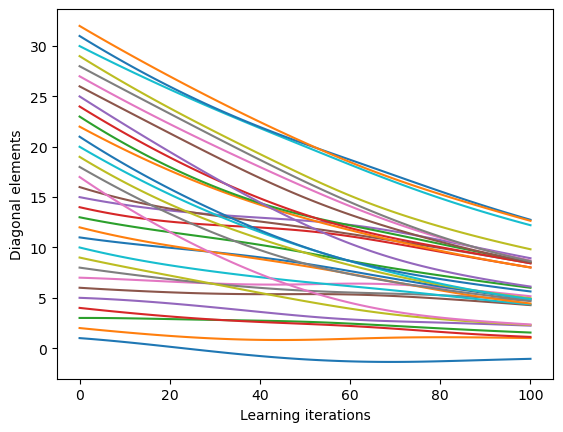

In [19]:
cost = DoubleBracketCostFunction.least_squares
nqubits = 5
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))

step = 1e-2
iterations = 100
d, loss, grad, diags = gradient_ascent(dbi, d,step, iterations)

plt.figure()
plt.plot(range(iterations+1), loss)
plt.xlabel('Learning iterations')
plt.ylabel('Loss: Least squares')

plt.figure()
for i in range(2**nqubits):
    plt.plot(diags[i,:], label='State ' + str(i))
plt.xlabel('Learning iterations')
plt.ylabel('Diagonal elements')


Text(0, 0.5, '$||\\sigma(H_k)||$')

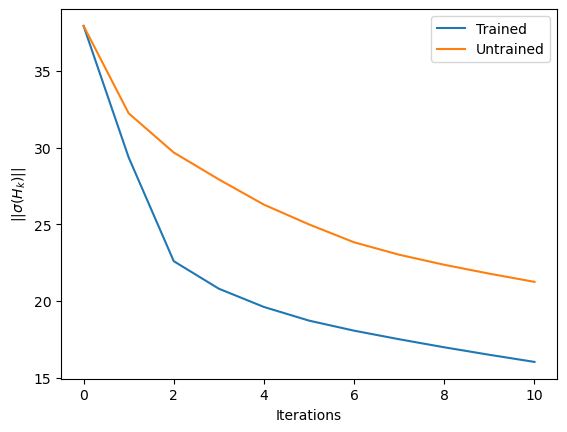

In [22]:
cost = DoubleBracketCostFunction.least_squares
nqubits = 5
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=3.0)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
d_fixed = np.diag(np.linspace(1,2**nqubits,2**nqubits))
d_trained = deepcopy(d_fixed)
dbi_trained = deepcopy(dbi)
flows = 10
iterations = 30
off_diagonal_norm = np.empty((2,flows+1))
off_diagonal_norm[0,0] = dbi_trained.off_diagonal_norm
off_diagonal_norm[1,0] = dbi.off_diagonal_norm

for i in range(flows):
    d_trained, loss, grad, diags = gradient_ascent(dbi_trained, d_trained,step, iterations)
    s = dbi_trained.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d_trained, n=3)
    dbi_trained(s,d=d_trained)
    off_diagonal_norm[0,i+1] = dbi_trained.off_diagonal_norm
    s = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d_fixed, n=3)
    dbi(s,d=d_fixed)
    off_diagonal_norm[1,i+1] = dbi.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm[0,:], label='Trained')
plt.plot(off_diagonal_norm[1,:], label='Untrained')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')

